## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [467]:
# Импорт библиотек
!pip install --upgrade numpy==1.22.0
!pip install colored

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from collections import OrderedDict
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
from math import ceil
import random
from termcolor import colored

pd.set_option('chained_assignment',None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STATE = 42
MAIN_FOLDER = '/kaggle/input/dataset/to_upload/'
TRAIN_IMAGES_FOLDER = '/kaggle/input/dataset/to_upload/train_images'
TEST_IMAGES_FOLDER = '/kaggle/input/dataset/to_upload/test_images'

In [468]:
# Функция для проверки датафрейма
def check_dataframe(df):
    print("=" * 50)
    print("===== Проверка DataFrame =====")
    print("=" * 50)
    
    # Проверка на дубликаты строк в DataFrame
    if df.duplicated().any():
        duplicates_percent = df.duplicated().mean()
        print(f"Процент дубликатов строк в DataFrame: {duplicates_percent:.1%}")
    else:
        print("В DataFrame нет дубликатов строк.")
    
    # Проверка на дубликаты внутри каждой колонки
    for col in df.columns:
        col_duplicates_percent = df[col].duplicated().mean()
        print(f"Процент дубликатов в колонке '{col}': {col_duplicates_percent:.1%}")
    
    # Проверка на пропуски
    if df.isnull().values.any():
        missing_percent = df.isnull().mean()
        print(f"Процент пропущенных значений в DataFrame: {missing_percent:.1%}")
    else:
        print("В DataFrame нет пропущенных значений.\n")
        
    # Проверка на уникальные значения в каждой колонке
    print("Уникальные значения в DataFrame:")
    for col in df.columns:
        unique_values = df[col].nunique()
        print(f"Количество уникальных значений в колонке '{col}': {unique_values}")
    print("\n")
        
    # Проверка на типы данных
    print("Типы данных в DataFrame:")
    print(df.dtypes)
    print("=" * 50)

In [469]:
# Загрузка данных
train_data = pd.read_csv(os.path.join(MAIN_FOLDER, 'train_dataset.csv'))
crowd_annotations = pd.read_csv(os.path.join(MAIN_FOLDER, 'CrowdAnnotations.tsv'), sep='\t', header=None, 
                                names=['image', 
                                       'query_id',
                                       'agreement_rate',
                                       'matched_count',
                                       'mismatched_count'])

expert_annotations = pd.read_csv(os.path.join(MAIN_FOLDER, 'ExpertAnnotations.tsv'), sep='\t', header=None,
                                 names=['image', 
                                        'query_id',
                                        'expert_1_score',
                                        'expert_2_score',
                                        'expert_3_score'])

test_queries = pd.read_csv(os.path.join(MAIN_FOLDER, 'test_queries.csv'), sep='|').drop('Unnamed: 0', axis=1)

# Вывод данных
display(train_data.head())
display(crowd_annotations.head())
display(expert_annotations.head())
display(test_queries.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image                     query_id  agreement_rate  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2             0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2             0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2             0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2             0.0   

   matched_count  mismatched_count  
0              3                 0  
1              0                 3  
2              0                 3  
3              0                 3  
4              0                 3

image                     query_id  expert_1_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2               1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2               1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2               1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2               1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2               1   

   expert_2_score  expert_3_score  
0               1               1  
1               1               2  
2               1               2  
3               2               2  
4               1               2

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [470]:
check_dataframe(train_data)

===== Проверка DataFrame =====
В DataFrame нет дубликатов строк.
Процент дубликатов в колонке 'image': 82.8%
Процент дубликатов в колонке 'query_id': 83.2%
Процент дубликатов в колонке 'query_text': 83.2%
В DataFrame нет пропущенных значений.

Уникальные значения в DataFrame:
Количество уникальных значений в колонке 'image': 1000
Количество уникальных значений в колонке 'query_id': 977
Количество уникальных значений в колонке 'query_text': 977


Типы данных в DataFrame:
image         object
query_id      object
query_text    object
dtype: object


In [471]:
check_dataframe(crowd_annotations)

===== Проверка DataFrame =====
В DataFrame нет дубликатов строк.
Процент дубликатов в колонке 'image': 97.9%
Процент дубликатов в колонке 'query_id': 97.9%
Процент дубликатов в колонке 'agreement_rate': 100.0%
Процент дубликатов в колонке 'matched_count': 100.0%
Процент дубликатов в колонке 'mismatched_count': 100.0%
В DataFrame нет пропущенных значений.

Уникальные значения в DataFrame:
Количество уникальных значений в колонке 'image': 1000
Количество уникальных значений в колонке 'query_id': 1000
Количество уникальных значений в колонке 'agreement_rate': 12
Количество уникальных значений в колонке 'matched_count': 6
Количество уникальных значений в колонке 'mismatched_count': 7


Типы данных в DataFrame:
image                object
query_id             object
agreement_rate      float64
matched_count         int64
mismatched_count      int64
dtype: object


In [472]:
check_dataframe(expert_annotations)


===== Проверка DataFrame =====
В DataFrame нет дубликатов строк.
Процент дубликатов в колонке 'image': 82.8%
Процент дубликатов в колонке 'query_id': 83.2%
Процент дубликатов в колонке 'expert_1_score': 99.9%
Процент дубликатов в колонке 'expert_2_score': 99.9%
Процент дубликатов в колонке 'expert_3_score': 99.9%
В DataFrame нет пропущенных значений.

Уникальные значения в DataFrame:
Количество уникальных значений в колонке 'image': 1000
Количество уникальных значений в колонке 'query_id': 977
Количество уникальных значений в колонке 'expert_1_score': 4
Количество уникальных значений в колонке 'expert_2_score': 4
Количество уникальных значений в колонке 'expert_3_score': 4


Типы данных в DataFrame:
image             object
query_id          object
expert_1_score     int64
expert_2_score     int64
expert_3_score     int64
dtype: object


In [473]:
check_dataframe(test_queries)

===== Проверка DataFrame =====
В DataFrame нет дубликатов строк.
Процент дубликатов в колонке 'query_id': 0.0%
Процент дубликатов в колонке 'query_text': 0.0%
Процент дубликатов в колонке 'image': 80.0%
В DataFrame нет пропущенных значений.

Уникальные значения в DataFrame:
Количество уникальных значений в колонке 'query_id': 500
Количество уникальных значений в колонке 'query_text': 500
Количество уникальных значений в колонке 'image': 100


Типы данных в DataFrame:
query_id      object
query_text    object
image         object
dtype: object


In [474]:
# Создание колонки agreement_rate
scaler = MinMaxScaler()
expert_annotations['agreement_rate'] = scaler.fit_transform(expert_annotations.loc[:, 'expert_1_score':'expert_3_score']).mean(axis=1)

In [475]:
# Объединение датафреймов по полю 'image' и 'query_id'
merged_annotations = expert_annotations[['image', 'query_id', 'agreement_rate']].merge(
                                              crowd_annotations[['image', 'query_id', 'agreement_rate']],
                                              on=['image', 'query_id'], 
                                              how='left',
                                              suffixes=('_expert', '_crowd')
    )

# Вычисление итоговой оценки как суммы экспертных и краудсорсинговых оценок, умноженных на соответствующие веса
weights = [0.6, 0.4]
merged_annotations['final_score'] = merged_annotations[['agreement_rate_expert', 'agreement_rate_crowd']].apply(lambda x: sum(a * b for a, b in zip(x, weights)), axis=1)
merged_annotations.loc[merged_annotations['agreement_rate_crowd'].isna(), 'final_score'] = merged_annotations.loc[merged_annotations['agreement_rate_crowd'].isna(), 'agreement_rate_expert']

# Объединим датафрейм с описанием изображений с целевой переменной
train_data = train_data.merge(merged_annotations[['image', 'query_id', 'final_score']], how='left', on=['image', 'query_id'])
train_data['final_score'] = train_data['final_score']

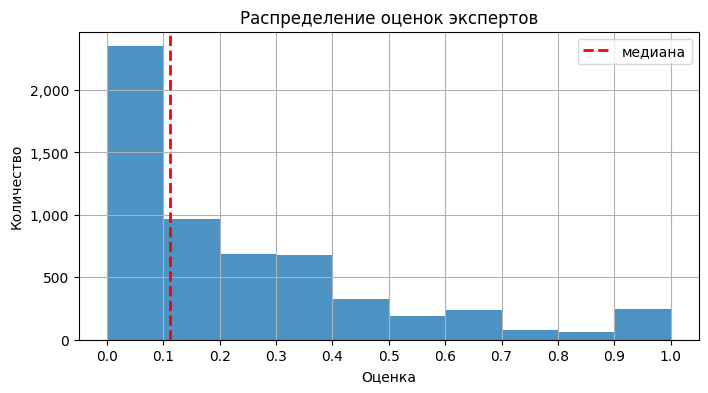

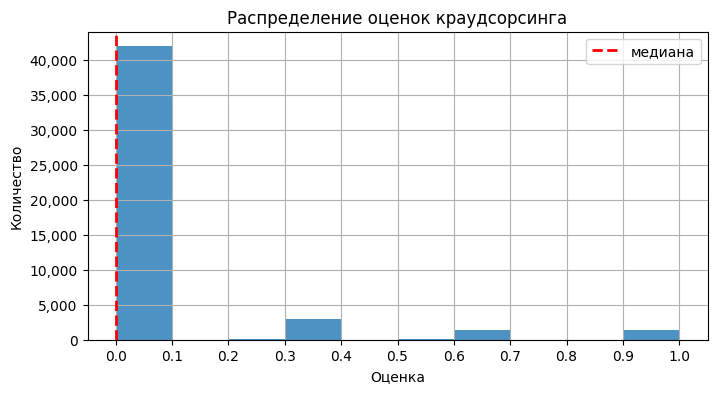

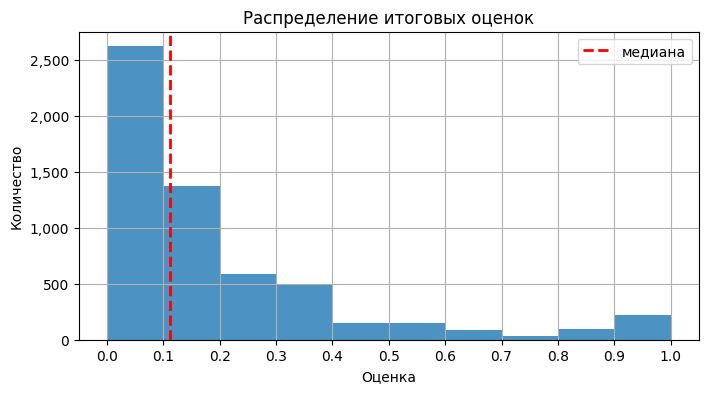

In [476]:
# Распределение оценок экспертов
plt.figure(figsize=(8, 4))
plt.hist(expert_annotations['agreement_rate'], color='tab:blue', alpha=0.8)
plt.axvline(x=expert_annotations['agreement_rate'].median(), linewidth=2, color='r', linestyle='--', label='медиана', alpha=1)
plt.title("Распределение оценок экспертов")
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.grid()
plt.legend()
plt.xticks(np.arange(0, expert_annotations['agreement_rate'].max()+0.1, 0.1))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.show()

# Распределение оценок краудсорсинга
plt.figure(figsize=(8, 4))
plt.hist(crowd_annotations['agreement_rate'], color='tab:blue', alpha=0.8)
plt.axvline(x=crowd_annotations['agreement_rate'].median(), linewidth=2, color='r', linestyle='--', label='медиана', alpha=1)
plt.title("Распределение оценок краудсорсинга")
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.grid()
plt.legend()
plt.xticks(np.arange(0, crowd_annotations['agreement_rate'].max()+0.1, 0.1))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.show()


# Распределение итоговых оценок
plt.figure(figsize=(8, 4))
plt.hist(train_data['final_score'], color='tab:blue', alpha=0.8)
plt.axvline(x=train_data['final_score'].median(), linewidth=2, color='r', linestyle='--', label='медиана', alpha=1)
plt.title("Распределение итоговых оценок")
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.grid()
plt.legend()
plt.xticks(np.arange(0, train_data['final_score'].max()+0.1, 0.1))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.show()

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

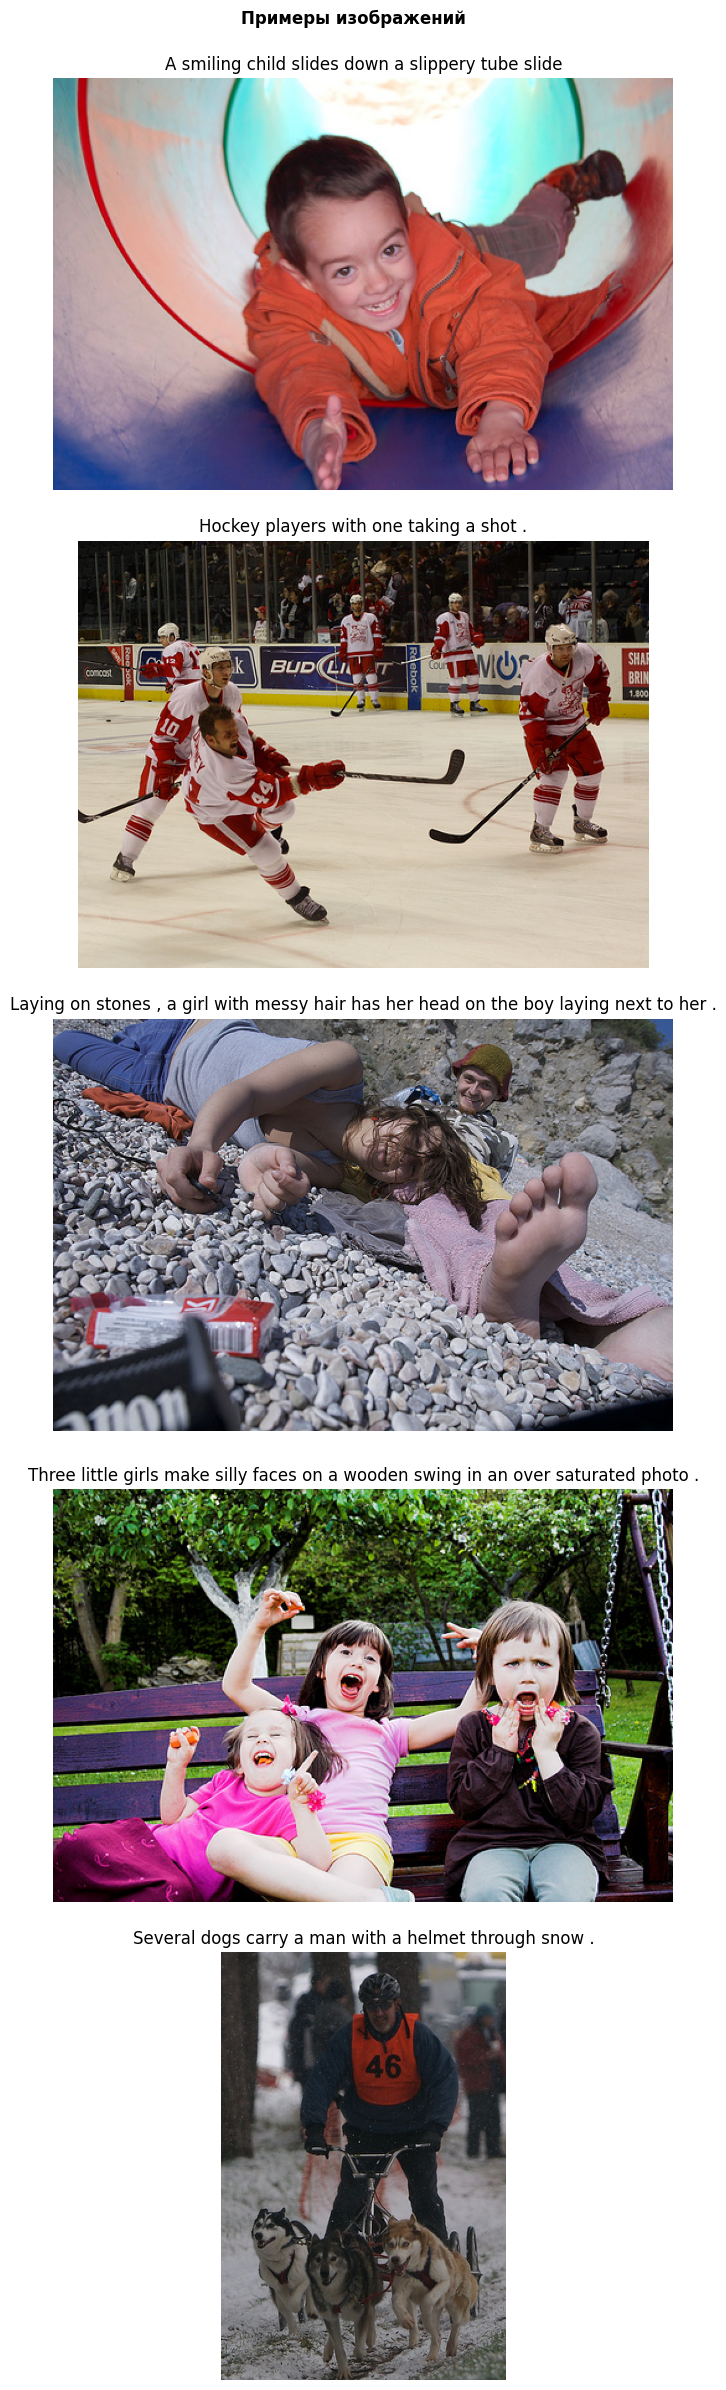

In [477]:
# Создание словаря соответствия query_id и query_text
query_id_to_text = dict(zip(train_data['query_id'].str[:-2], train_data['query_text']))

# Отобразим несколько изображений
image_paths = [os.path.join(TRAIN_IMAGES_FOLDER, filename) for filename in train_data['image'].sample(5, random_state=STATE)]

# Создание сетки изображений
fig, axes = plt.subplots(5, 1, figsize=(8, 30))
fig.suptitle('Примеры изображений', fontweight='bold', y=0.9)

# Настройка вертикального расстояния между изображениями
plt.subplots_adjust(hspace=0.1)

# Итерация по изображениям
for ax, image_path in zip(axes.ravel(), image_paths):
    image_name = os.path.basename(image_path)  # Получаем имя файла как query_id
    query_text = query_id_to_text.get(image_name, 'Unknown')  # Получаем соответствующий текст запроса
    image = plt.imread(image_path)
    ax.imshow(image)
    ax.set_title(f"{query_text}", wrap=True)
    ax.axis('off')

plt.show()

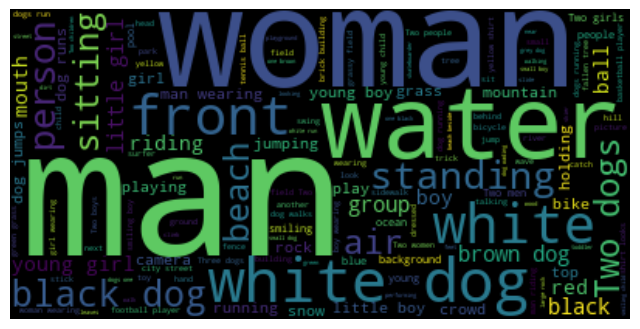

In [478]:
# Объединим текст из колонки query_text
text = ' '.join(train_data['query_text'])

# Создадим облако слов
wordcloud = WordCloud().generate(text)

# Отобразим облако слов
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [479]:
# Создадим список с ключевыми словами
keywords = ['child', 
            'children', 
            'kid', 
            'boy', 
            'girl',
            'baby',
            'teenager', 
            'toddler']

# Получим названия изображений с ключевыми словами в описании
restricted_images =  list(train_data[train_data['query_text'].str.contains('|'.join(keywords), 
                                                                           case=False)]['query_id'].str[:-2].unique())

# Применим фильтр для удаления изображений, содержащих изображения детей
train_data = train_data[~train_data['image'].isin(restricted_images)].reset_index(drop=True)

print(f'Удалено {len(restricted_images)} изображений')
print('Размер датасета:', train_data.shape[0])


Удалено 292 изображений
Размер датасета: 4076


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [480]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Доступно устройство CUDA: {torch.cuda.get_device_name(0)}")
    print(f"Доступный объем памяти на устройстве: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA не доступен.")

Доступно устройство CUDA: Tesla P100-PCIE-16GB
Доступный объем памяти на устройстве: 15.89 GB


In [481]:
# Загрузка предварительно обученной модели ResNet-18
def vectorize_image(images_folder, device):
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    for param in model.parameters():
        param.requires_grad_(False)

    # Перенос модели на устройство GPU
    model.to(device)

    # Удаление последнего полносвязного слоя
    model = torch.nn.Sequential(*list(model.children())[:-2])

    # Добавление глобального пулинга
    model.add_module("GlobalAvgPool", nn.AdaptiveAvgPool2d((1, 1)))

    # Перевод модели в режим инференса
    model.eval()

    # Загрузка и предобработка изображений
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Словарь для хранения эмбедингов изображений
    image_embeddings = {}

    # Проходим по всем файлам в папке и извлекаем эмбединги
    for filename in tqdm(os.listdir(images_folder), desc="Processing images"):
        image_path = os.path.join(images_folder, filename)
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image)  # Предобрабатываем изображение
        image = image.unsqueeze(0)  # Добавляем размерность батча
        image = image.to(device)  # Переносим изображение на устройство (GPU)
        with torch.no_grad():  
            vector = model(image)  
            vector = vector.squeeze()  
            flattened_vector = torch.flatten(vector)  # Выпрямление вектора
            image_embeddings[filename] = flattened_vector.cpu().numpy()  # Сохраняем эмбединг в словаре

        # Очистка тензоров после использования
        del image, vector, flattened_vector
        torch.cuda.empty_cache()

    return image_embeddings

In [482]:
# Получение эмбедингов изображений
train_image_embeddings = vectorize_image(TRAIN_IMAGES_FOLDER, device)

# Применение эмбедингов к датафрейму и создание массива numpy
train_image_vectors = np.array(train_data['image'].map(lambda x: train_image_embeddings.get(x)).values.tolist())

Processing images: 100%|██████████| 1000/1000 [00:10<00:00, 92.81it/s]


In [483]:
train_image_vectors.shape

(4076, 512)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [484]:
def vectorize_text(texts, device):

    # Загрузка предобученной модели BERT и токенизатора
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    # Перенос модели на GPU
    model.to(device)
    
    # Перевод модели в режим инференса
    model.eval()
    
    # Удаление дубликатов из списка текстов
    unique_texts = list(OrderedDict.fromkeys(texts))

    text_embeddings = {}
    for text in tqdm(unique_texts, desc="Vectorizing text"):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)  # Токенизация текста и преобразование в тензор

        for key in inputs:  # Перенос тензоров на GPU
            inputs[key] = inputs[key].to(device)

        with torch.no_grad():  # Получение эмбеддингов из модели BERT
            outputs = model(**inputs)

        text_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Векторное представление текста
        text_embeddings[text] = text_embedding
    
        del inputs, outputs # Удаление тензоров после использования
        torch.cuda.empty_cache()
        
    return text_embeddings

In [485]:
# Получение эмбедингов текстов
train_text_embeddings = vectorize_text(train_data['query_text'], device)

# Применение эмбедингов к датафрейму и создание массива numpy
train_text_vectors = np.array(train_data['query_text'].map(lambda x: train_text_embeddings.get(x).flatten()).values.tolist())

Vectorizing text: 100%|██████████| 941/941 [00:08<00:00, 105.17it/s]


In [486]:
train_text_vectors.shape

(4076, 768)

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [487]:
combined_vectors = np.hstack([train_image_vectors, train_text_vectors])
df = pd.DataFrame(combined_vectors)
df['score'] = train_data['final_score']
df['image'] = train_data['image']
df.shape

(4076, 1282)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [488]:
# Создание объекта GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=STATE)

# Определение целевой переменной и признака для группировки
train_indices, test_indices = next(gss.split(X=df.drop(columns=['score', 'image']), 
                                             y=df['score'], 
                                             groups=df['image']))

# Разделение данных на тренировочную и тестовую выборки
train_df, test_df = df.loc[train_indices], df.loc[test_indices]
X_train = train_df.drop(columns=['score', 'image'])
X_test = test_df.drop(columns=['score', 'image'])
y_train = train_df['score']
y_test = test_df['score']

  0%|          | 1/250 [00:00<00:32,  7.64it/s]

Epoch: 0/250


  4%|▍         | 11/250 [00:01<00:29,  8.05it/s]

Epoch: 10/250
MAE = 0.3978232741355896
Loss = 0.27164047956466675



  8%|▊         | 21/250 [00:02<00:27,  8.20it/s]

Epoch: 20/250
MAE = 0.33899804949760437
Loss = 0.2289055585861206



 12%|█▏        | 31/250 [00:03<00:26,  8.33it/s]

Epoch: 30/250
MAE = 0.3048475682735443
Loss = 0.24659526348114014



 16%|█▋        | 41/250 [00:04<00:26,  7.96it/s]

Epoch: 40/250
MAE = 0.2808796465396881
Loss = 0.10827969014644623



 20%|██        | 51/250 [00:06<00:25,  7.89it/s]

Epoch: 50/250
MAE = 0.2612198293209076
Loss = 0.09100412577390671



 24%|██▍       | 61/250 [00:07<00:23,  8.15it/s]

Epoch: 60/250
MAE = 0.24567832052707672
Loss = 0.040713705122470856



 28%|██▊       | 71/250 [00:08<00:21,  8.29it/s]

Epoch: 70/250
MAE = 0.23417821526527405
Loss = 0.19778203964233398



 32%|███▏      | 81/250 [00:09<00:20,  8.29it/s]

Epoch: 80/250
MAE = 0.22651545703411102
Loss = 0.24970266222953796



 36%|███▋      | 91/250 [00:11<00:19,  8.27it/s]

Epoch: 90/250
MAE = 0.22082549333572388
Loss = 0.039456259459257126



 40%|████      | 101/250 [00:12<00:18,  8.23it/s]

Epoch: 100/250
MAE = 0.21516281366348267
Loss = 0.186508446931839



 44%|████▍     | 111/250 [00:13<00:16,  8.25it/s]

Epoch: 110/250
MAE = 0.21051006019115448
Loss = 0.18760204315185547



 48%|████▊     | 121/250 [00:14<00:17,  7.37it/s]

Epoch: 120/250
MAE = 0.20698858797550201
Loss = 0.21376100182533264



 52%|█████▏    | 131/250 [00:16<00:14,  8.02it/s]

Epoch: 130/250
MAE = 0.2031444013118744
Loss = 0.18100862205028534



 56%|█████▋    | 141/250 [00:17<00:13,  7.83it/s]

Epoch: 140/250
MAE = 0.20042116940021515
Loss = 0.024935651570558548



 60%|██████    | 151/250 [00:18<00:12,  8.10it/s]

Epoch: 150/250
MAE = 0.19809967279434204
Loss = 0.17717288434505463



 64%|██████▍   | 161/250 [00:19<00:10,  8.34it/s]

Epoch: 160/250
MAE = 0.19636525213718414
Loss = 0.08843030035495758



 68%|██████▊   | 171/250 [00:21<00:09,  8.07it/s]

Epoch: 170/250
MAE = 0.19549988210201263
Loss = 0.03915712237358093



 72%|███████▏  | 181/250 [00:22<00:08,  8.01it/s]

Epoch: 180/250
MAE = 0.19392645359039307
Loss = 0.11352785676717758



 76%|███████▋  | 191/250 [00:23<00:07,  8.35it/s]

Epoch: 190/250
MAE = 0.19250249862670898
Loss = 0.0437600314617157



 80%|████████  | 201/250 [00:24<00:06,  8.10it/s]

Epoch: 200/250
MAE = 0.19186343252658844
Loss = 0.04314356669783592



 84%|████████▍ | 211/250 [00:26<00:04,  8.26it/s]

Epoch: 210/250
MAE = 0.19128355383872986
Loss = 0.038194380700588226



 88%|████████▊ | 221/250 [00:27<00:03,  7.97it/s]

Epoch: 220/250
MAE = 0.1903361976146698
Loss = 0.02584867738187313



 92%|█████████▏| 231/250 [00:28<00:02,  8.20it/s]

Epoch: 230/250
MAE = 0.1893552839756012
Loss = 0.07785303890705109



 96%|█████████▋| 241/250 [00:29<00:01,  8.14it/s]

Epoch: 240/250
MAE = 0.1886744499206543
Loss = 0.014798877760767937



Best train epoch 249
Best train score 0.1612
Best test epoch 245
Best test score 0.1886


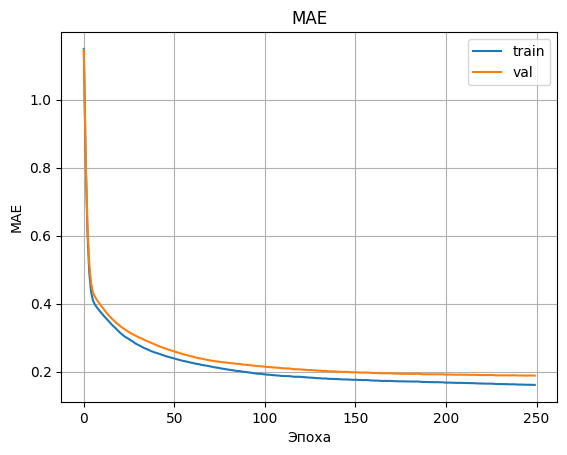

In [489]:
# Создание полносвязной нейронной сети
class Net(nn.Module):
    def __init__(self,
                 n_in_neurons,
                 n_hidden_neurons_1,
                 n_hidden_neurons_2,
                 n_out_neurons=1,
                 p=0):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        nn.init.xavier_normal_(self.fc1.weight)
        self.act1 = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=p)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        nn.init.xavier_normal_(self.fc2.weight)
        self.act2 = nn.LeakyReLU()
        self.dp2 = nn.Dropout(p=p)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.dp1(x)
        x = self.act2(self.fc2(x))
        x = self.dp2(x)
        x = self.fc3(x)
        return x

    def fit(self,
            train,
            y_train,
            val=None,
            y_val=None,
            batch_size=16,
            num_epochs=10,
            lr=0.000001,
            plot_scores=True):

        self.train_scores = []
        self.best_train_score = float('inf')
        self.best_train_epoch = 0

        self.val_scores = []
        self.best_val_score = float('inf')
        self.best_val_epoch = 0

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss = nn.MSELoss().to(device)
        mae = nn.L1Loss().to(device)

        num_batches = ceil(train.shape[0] / batch_size)
        epoches = []

        for epoch in tqdm(range(num_epochs), leave=False):
            if epoch % 10 == 0:
                print(f'Epoch: {epoch}/{num_epochs}')
                try:
                    print(f'MAE = {score}')
                    print(f'Loss = {loss_value}')
                    print()
                except UnboundLocalError:
                    pass

            self.train()
            order = np.random.permutation(train.shape[0])
            epoches.append(epoch)

            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                batch_indexes = order[start_index:start_index + batch_size]
                X_batch = train[batch_indexes].to(device)
                y_batch = y_train[batch_indexes].to(device)
                optimizer.zero_grad()
                preds = self.forward(X_batch).flatten().to(device)
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

            self.eval()

            preds = self.forward(train).flatten().to(device)
            score = float(mae(preds, y_train))
            self.train_scores.append(score)

            if val is not None and y_val is not None:
                preds = self.forward(val).flatten()
                score = float(mae(preds, y_val))
                self.val_scores.append(score)

        self.best_train_score = min(self.train_scores)
        self.best_train_epoch = np.argmin(self.train_scores)

        try:
            self.best_val_score = min(self.val_scores)
            self.best_val_epoch = np.argmin(self.val_scores)
        except:
            pass

        if plot_scores:
            sns.lineplot(x=epoches, y=self.train_scores, label='train')

            print(f'Best train epoch {self.best_train_epoch}')
            print(f'Best train score {self.best_train_score:0.4f}')

            if val is not None and y_val is not None:
                sns.lineplot(x=epoches, y=self.val_scores, label='val')

                print(f'Best test epoch {self.best_val_epoch}')
                print(f'Best test score {self.best_val_score:0.4f}')
            plt.title('MAE')
            plt.xlabel('Эпоха')
            plt.ylabel('MAE')
            plt.legend()
            plt.grid()
            plt.show()

# Подготовка данных
X_train_tensor = torch.FloatTensor(train_df.drop(['score', 'image'], axis=1).values).to(device)
y_train_tensor = torch.FloatTensor(train_df['score'].values).to(device)

X_val_tensor = torch.FloatTensor(test_df.drop(['score', 'image'], axis=1).values).to(device)
y_val_tensor = torch.FloatTensor(test_df['score'].values).to(device)

# Создание и обучение нейронной сети
fc_nn = Net(X_train_tensor.shape[1], 256, 64, 1, 0.1).to(device)
fc_nn.fit(X_train_tensor,
          y_train_tensor,
          val=X_val_tensor,
          y_val=y_val_tensor,
          num_epochs=250,
          batch_size=32)


In [490]:
# Создание словаря для сохранения моделей
models_dict = {
    'CatBoost': CatBoostRegressor(verbose=0),
    'LGBM': LGBMRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'ElasticNet': ElasticNet()
}

# Создание словаря для хранения обученных моделей
trained_models = {}

# Создание списка для хранения результатов
results = []

# Подбор параметров и обучение моделей
for model_name, model in tqdm(models_dict.items(), leave=False):
    print(f"Обучаем модель {model_name}", end='\r')
    if model_name == 'CatBoost':
        param_dist = {
            'iterations': [10, 20],
            'learning_rate': [0.1, 0.2],
            'depth': [4, 5],
            'l2_leaf_reg': [3, 7],
            'random_state': [STATE]
        }
    elif model_name == 'LGBM':
        param_dist = {
            'n_estimators': [10, 20],
            'learning_rate': [0.1, 0.2],
            'max_depth': [4, 5],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'random_state': [STATE]
        }
    elif model_name == 'GradientBoosting':
        param_dist = {
            'n_estimators': [10, 20],
            'learning_rate': [0.1, 0.2],
            'max_depth': [4, 5],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 3],
            'random_state': [STATE] 
        }
    elif model_name == 'ElasticNet':
        param_dist = {
            'alpha': [0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.5, 0.9]
        }
    
    random_search = RandomizedSearchCV(model, 
                                       param_distributions=param_dist, 
                                       n_iter=3, 
                                       scoring=make_scorer(mean_absolute_error), 
                                       cv=5, 
                                       verbose=0, 
                                       n_jobs=-1, 
                                       random_state=STATE
    )

    random_search.fit(X_train, y_train)
    
    # Вычисление средней MAE на кросс-валидации
    mean_cv_mae = random_search.best_score_
    
    # Добавление результатов в список
    results.append({'Model': model_name, 'Mean CV MAE': mean_cv_mae})
    
    # Сохранение обученной модели в словаре
    trained_models[model_name] = random_search.best_estimator_

# Создание DataFrame из списка результатов
results_df = pd.DataFrame(results)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:19<00:57, 19.18s/it]

 50%|█████     | 2/4 [00:33<00:32, 16.26s/it]

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 75%|███████▌  | 3/4 [02:19<00:57, 57.22s/it]

In [491]:
display(results_df)
best_model_name = results_df.loc[results_df['Mean CV MAE'].idxmin(), 'Model']
print("\nЛучшая модель:", best_model_name)

Model  Mean CV MAE
0          CatBoost     0.186794
1              LGBM     0.178037
2  GradientBoosting     0.180815
3        ElasticNet     0.194850


Лучшая модель: LGBM


Для дальнейшей работы будем использовать модель LGBM, т.к. она показала лучший результат на кросс-валидации.

In [492]:
# Предсказание на тестовой выборке
y_pred_test = trained_models[best_model_name].predict(X_test)

# Вычисление MAE на тестовой выборке
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"MAE на тестовой выборке для модели {best_model_name}: {mae_test:.4f}")

MAE на тестовой выборке для модели LGBM: 0.1717


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [493]:
# Получение эмбедингов изображений
test_image_embeddings = vectorize_image(TEST_IMAGES_FOLDER, device)

# Применение эмбедингов к датафрейму и создание массива numpy
test_image_vectors = np.array(test_queries['image'].map(lambda x: test_image_embeddings.get(x)).values.tolist())

Processing images: 100%|██████████| 100/100 [00:01<00:00, 93.73it/s]


In [494]:
# Получение эмбедингов текстов
test_text_embeddings = vectorize_text(test_queries['query_text'], device)

# Применение эмбедингов к датафрейму и создание массива numpy
test_text_vectors = np.array(test_queries['query_text'].map(lambda x: test_text_embeddings.get(x).flatten()).values.tolist())

Vectorizing text: 100%|██████████| 500/500 [00:04<00:00, 101.58it/s]


In [500]:
test_combined_vectors = np.hstack([test_image_vectors, test_text_vectors])
final_test_df = pd.DataFrame(test_combined_vectors)
final_test_df[['image', 'query_text']] = test_queries[['image', 'query_text']]

X = final_test_df.drop(['image', 'query_text'], axis=1)
y_pred = trained_models[best_model_name].predict(X)
final_test_df['mae_pred'] = y_pred

In [502]:
# Функция для подобора изображения по описанию
def select_images(df, folder, image_size=(8, 8), fontsize=16):
    # Выбираем 10 случайных уникальных описаний изображений
    unique_descriptions = df['query_text'].unique()
    selected_descriptions = random.sample(list(unique_descriptions), 10)

    for description in selected_descriptions:
        # Получаем срез датафрейма с соответствующим описанием
        description_df = df[df['query_text'] == description]
        
        # Находим индекс изображения с минимальным значением MAE
        min_mae_index = description_df['mae_pred'].idxmin()
        
        # Получаем информацию об изображении с минимальным MAE
        image_info = description_df.loc[min_mae_index]
        
        # Получаем путь к изображению
        image_path = os.path.join(TEST_IMAGES_FOLDER, image_info['image'])
        
        # Проверка на запрещенные ключевые слова
        if keywords and any(word in description.lower() for word in keywords):
            print(colored("This image is unavailable in your country in compliance with local laws.\n", "red"))
            continue
        
        # Выводим информацию об изображении
        print(f"Описание: {description}")
        print(f"MAE: {image_info['mae_pred']:.4f}")
        
        # Отображаем изображение
        img = Image.open(image_path)
        plt.figure(figsize=image_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print()


Описание: A woman with glasses is sewing .
MAE: 0.1276


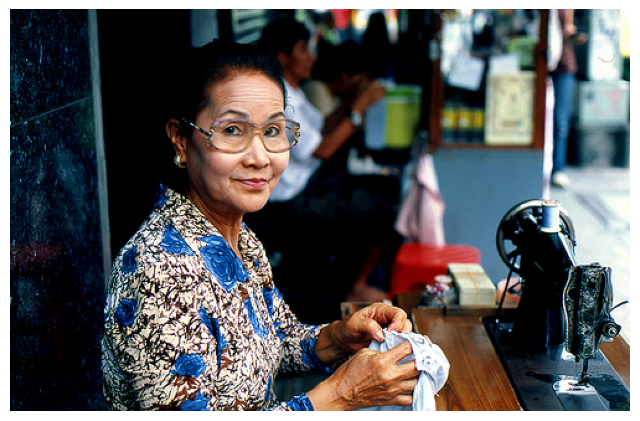


This image is unavailable in your country in compliance with local laws.

Описание: Five women in red shirts clapping .
MAE: 0.1286


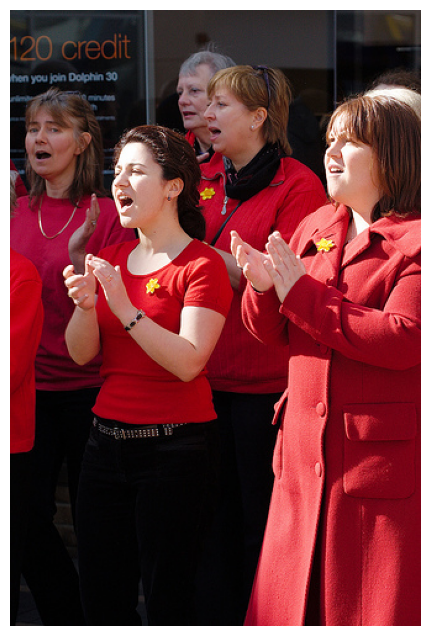


This image is unavailable in your country in compliance with local laws.

Описание: The small fluffy white dog runs through the green grass with a tiny stick in its mouth .
MAE: 0.2094


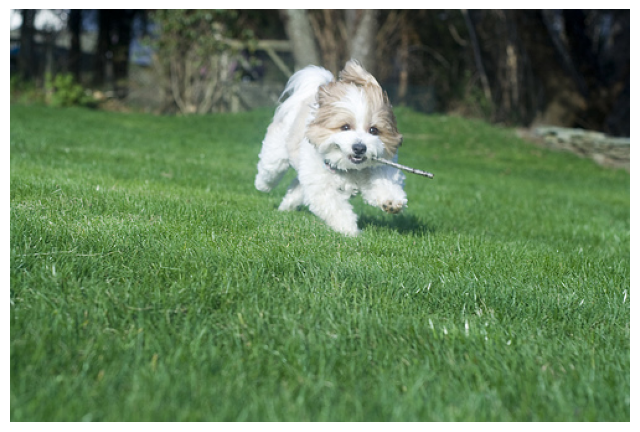


Описание: One person in a crowd of people , wearing a blue wig
MAE: 0.1500


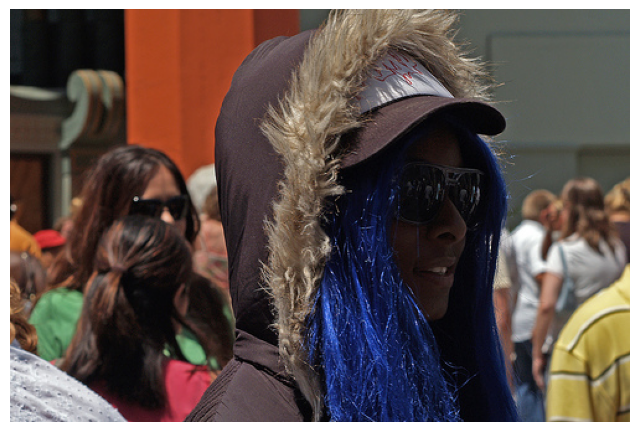


Описание: Seated man looks out at the ocean .
MAE: 0.3224


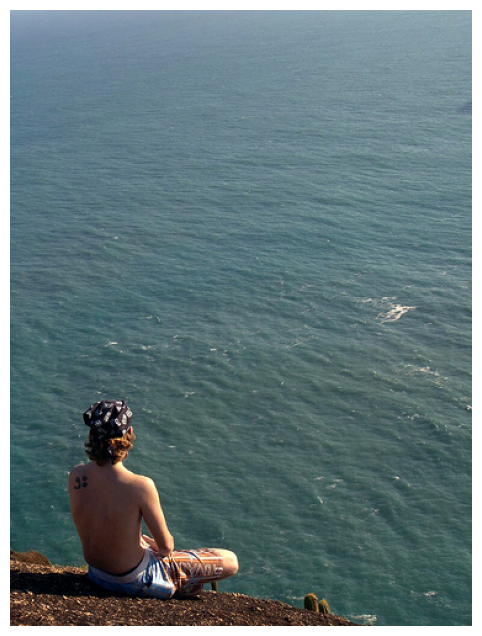


Описание: A man and a woman are running and jumping on top of a hill .
MAE: 0.1771


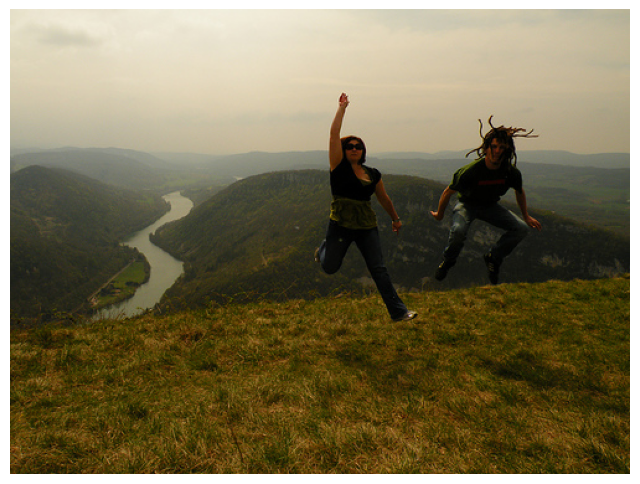


Описание: A caramel colored dog sits in front of trees looking forward .
MAE: 0.2027


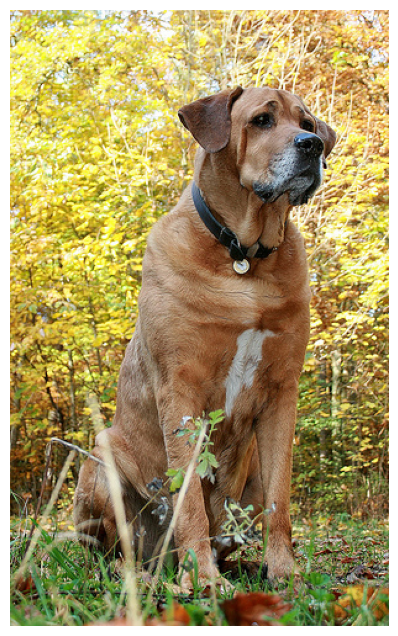


This image is unavailable in your country in compliance with local laws.



In [505]:
# Проверка модели
select_images(final_test_df, TEST_IMAGES_FOLDER)

Полученная модель показывает приемлемое качество подбора изображения по описанию.

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска